# Deep Convolutional GAN on SVHN
Implementation of DCGAN on the Street View House Numbers (SVHN) dataset.

## Importing required packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 

## Defining transforms

In [2]:
transform=transforms.ToTensor()

## Data colleciton

In [3]:
train_data=datasets.SVHN('data',split='train',download=True,transform=transform)

Using downloaded and verified file: data\train_32x32.mat


## Defining dataloader

In [4]:
batch_size=128
num_workers=0
train_loader=DataLoader(train_data,batch_size=batch_size,num_workers=num_workers,shuffle=True)

## Visualising a training batch

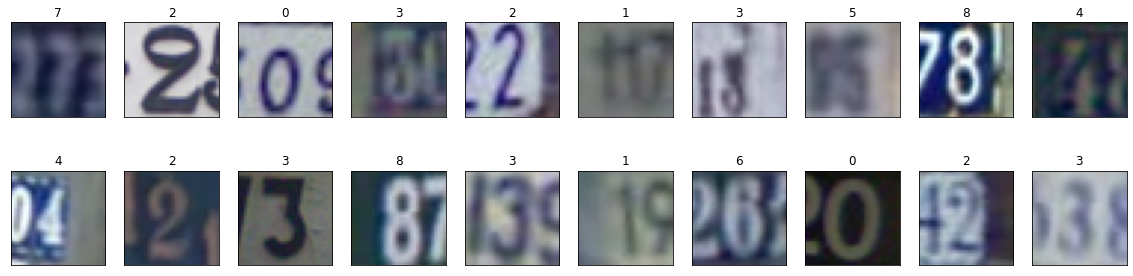

In [5]:
dataiter=iter(train_loader)
images,labels=dataiter.next()
plot_only=20
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
    ax = fig.add_subplot(2, plot_only/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

In [6]:
images,labels,images.shape,labels.shape

(tensor([[[[0.1725, 0.1725, 0.1725,  ..., 0.1922, 0.1765, 0.1647],
           [0.1725, 0.1725, 0.1725,  ..., 0.1882, 0.1725, 0.1647],
           [0.1725, 0.1725, 0.1765,  ..., 0.1922, 0.1804, 0.1725],
           ...,
           [0.3412, 0.3647, 0.3922,  ..., 0.3137, 0.3137, 0.3176],
           [0.3059, 0.3255, 0.3490,  ..., 0.2745, 0.2745, 0.2745],
           [0.2824, 0.3020, 0.3255,  ..., 0.2510, 0.2510, 0.2510]],
 
          [[0.2039, 0.2039, 0.2000,  ..., 0.2196, 0.2078, 0.2000],
           [0.2039, 0.2039, 0.2000,  ..., 0.2157, 0.2039, 0.1961],
           [0.2039, 0.2039, 0.2078,  ..., 0.2196, 0.2078, 0.2000],
           ...,
           [0.3686, 0.3922, 0.4235,  ..., 0.3529, 0.3569, 0.3569],
           [0.3412, 0.3608, 0.3882,  ..., 0.3176, 0.3176, 0.3216],
           [0.3216, 0.3412, 0.3686,  ..., 0.2980, 0.2980, 0.2980]],
 
          [[0.2784, 0.2745, 0.2706,  ..., 0.2902, 0.2745, 0.2667],
           [0.2784, 0.2745, 0.2706,  ..., 0.2902, 0.2745, 0.2627],
           [0.2863, 0.28

## Scaling data

In [7]:
def scale(x):
    x=x*2-1
    return x

## Discriminator architecture

In [8]:
def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    conv=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)
    layers.append(conv)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim=32):
        super(Discriminator,self).__init__()
        self.conv_dim=conv_dim

        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4)
        self.conv3=conv(conv_dim*2,conv_dim*4,4)
        
        self.fc=nn.Linear(conv_dim*4*4*4,1)

    def forward(self,x):

        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=x.view(-1,self.conv_dim*4*4*4)
        out=self.fc(x)
        return out

## Generator architecture

In [10]:
def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    transpose_conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)
    layers.append(transpose_conv)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim=32):
        super(Generator,self).__init__()
        self.conv_dim=conv_dim
        self.fc=nn.Linear(z_size,conv_dim*4*4*4)

        self.deconv1=deconv(conv_dim*4,conv_dim*2,4)
        self.deconv2=deconv(conv_dim*2,conv_dim,4)
        self.deconv3=deconv(conv_dim,3,4,batch_norm=False)


    def forward(self,x):
        x=self.fc(x)
        x=x.view(-1,self.conv_dim*4,4,4)
        x=F.relu(self.deconv1(x))
        x=F.relu(self.deconv2(x))
        out=F.tanh(self.deconv3(x))
        return out




In [12]:
def weights_init_normal(m):
    classname=m.__class__.__name__

    if hasattr(m,'weights') and (classname.find('Linear') or classname.find('conv'))!=-1:
        m.weight.data.normal_(0.0,0.02)

        if hasattr(m,'bias') and m.bias is not None:
            m.bias.data.zero_()

In [13]:
z_size=100
D=Discriminator(32)
G=Generator(z_size,32)

D.apply(weights_init_normal),G.apply(weights_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()

print(f"{D}\n\n\n{G}\n\n\nGPU on:{use_cuda and torch.cuda.is_available()}")

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

In [14]:
def real_loss(D_out,smooth=False):
    batch_size = D_out.size(0)

    if smooth:
        labels = torch.ones(batch_size) * 0.9
        
    else:
        labels = torch.ones(batch_size)


    if use_cuda and torch.cuda.is_available():
        labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.zeros(batch_size)

    if use_cuda and torch.cuda.is_available():
        labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss    

In [15]:
d_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))

In [16]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if use_cuda and torch.cuda.is_available():
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if use_cuda and torch.cuda.is_available():
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if use_cuda and torch.cuda.is_available():
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if use_cuda and torch.cuda.is_available():
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.4916 | g_loss: 0.8248
Epoch [    1/   50] | d_loss: 0.2542 | g_loss: 3.1835
Epoch [    2/   50] | d_loss: 0.3963 | g_loss: 2.8268
Epoch [    2/   50] | d_loss: 0.6748 | g_loss: 1.5826
Epoch [    3/   50] | d_loss: 0.5958 | g_loss: 1.9599
Epoch [    3/   50] | d_loss: 0.4737 | g_loss: 2.6774
Epoch [    4/   50] | d_loss: 0.3565 | g_loss: 3.5525
Epoch [    4/   50] | d_loss: 0.4265 | g_loss: 2.7550
Epoch [    5/   50] | d_loss: 1.8516 | g_loss: 4.4131
Epoch [    5/   50] | d_loss: 0.3448 | g_loss: 2.7679
Epoch [    6/   50] | d_loss: 0.1433 | g_loss: 3.1249
Epoch [    6/   50] | d_loss: 0.1704 | g_loss: 2.4416
Epoch [    7/   50] | d_loss: 0.2424 | g_loss: 3.2522
Epoch [    7/   50] | d_loss: 0.2162 | g_loss: 3.7570
Epoch [    8/   50] | d_loss: 0.2525 | g_loss: 3.6808
Epoch [    8/   50] | d_loss: 0.1094 | g_loss: 4.2263
Epoch [    9/   50] | d_loss: 0.1946 | g_loss: 2.5402
Epoch [    9/   50] | d_loss: 0.1204 | g_loss: 2.6493
Epoch [   10/   50] | d_loss

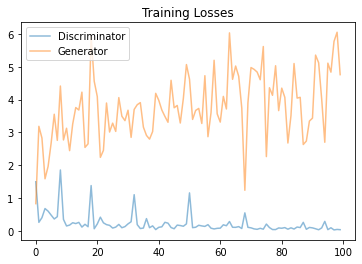

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [18]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

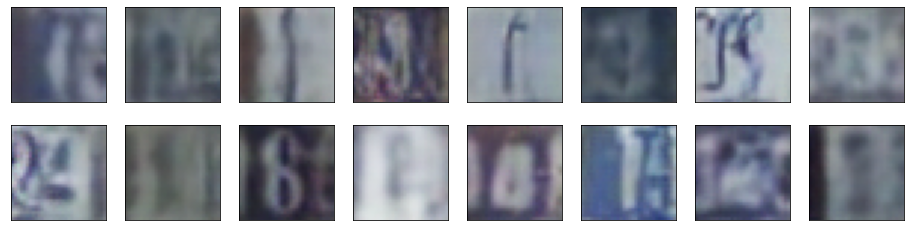

In [19]:
_ = view_samples(-1, samples)